<a href="https://colab.research.google.com/github/pinellolab/DNA-Diffusion/blob/update-vqvae/notebooks/experiments/conditional_diffusion/VQ_VAE_LATENT_SPACE_WITH_METRICS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Changes to the notebook:

1. Additional metrics to validate the approach: [NOTE: some of these metrics can be repurposed for the UNET (stable diffusion part)]

       a) **METRIC 1**, Recovery, defined as the percentage of fully (meaning not just parts of the sequence for)  predicted/recovered motifs from the validation set [Similiar metric is used in molecular generation as well]
       b) **METRIC 2** Partial recovery, defined as the percentage of the motifs where we predicted atleast RECOVERY_THRESHOLD correctly, independent wether the whole sequence was predicted correctly. This RECOVER_THRESHOLD is a variable, so if we set it 50% then we count the percentage of motifs where we recovered atleast 50% of the nucleotides of that sequence.
       b) **METRIC 3** Accuracy, defined as the percentage of nucleotides that we predicted correctly, independent wether the whole sequence was predicted correctly.
       c) **METRIC 4**, Seperation of the latent space using low dimensional visuals, UMAP. If we can see clear seperation in lower dimensional space, that means that latent variables are not bad.
       d) **METRIC 5** Seperation of the latent space using low dimensional visuals, non-linear projection t-SNE. If we can see clear seperation in lower dimensional space, that means that latent variables are not bad. 
       e) **METRIC 6**, Comparing different lengths of motifs (7-9-11) to a Jaspar vertrabrates DB using gimme scan.
       f) [weak metric/proxys] **METRIC 7**, observing the composite loss and perplexity during training. Perplexity should go up and composite lose should go down. 
       
**Perplexity**: In the context of a VQ-VAE (Vector Quantized Variational Autoencoder), perplexity is a measure of how well the model can reconstruct a given input. It is defined as the exponentiated average log-probability of the input, where the log-probability is computed using the model's decoder.

Perplexity can be thought of as a measure of how "surprised" the model is by the input. A low perplexity indicates that the model is able to reconstruct the input well and is not surprised by it, whereas a high perplexity indicates that the model is unable to reconstruct the input well and is surprised by it.

***NOTE : For all 7 Metrics (except recovery, there we rebuild little 100% of motifs, which is a good thing, we dont want to overfit) we observe favorable trends, where we can infer that the learning happens and we are finding a desired representation!***  
   
2. Split the test set into 3 distinct chromosomes, with expectation that different chromosomes will have different latent space. The same analysis should be repeated for different cell types.
3. Complete pre-refactoring of the code, cleaning and writing doc strings. This is ready to be copied and merged into codebase.
4. Adjusted the architecture for the VQ-VAE from https://github.com/zalandoresearch/pytorch-vq-vae
5. Added theoretical explanations and motivations of different parts of the code.
6. Reconcile different things between baseline stable diffusion nb and this one (similiar functions, variable naming, descriptions etc) such that refactoring is easier.

This notebook is divided in following chapters:

1. Utility functions
2. Data import and preperation
3. VQ-VAE architecture
4. VQ-VAE training metric functions and evaluation

In [1]:
%%capture
!pip install einops umap-learn torchmetrics livelossplot
!pip install gimmemotifs    #can take around 10 minutes
!genomepy install hg38

In [2]:
from IPython.core.debugger import set_trace
from matplotlib import pyplot as plt
import pylab
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import proj3d
%matplotlib inline
%pylab inline
import torch
import copy
import random
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as T
import torch
from IPython.display import display
import torch.nn as nn
from sklearn.manifold import TSNE
import os; os.getpid()
import pandas as pd
import numpy as np
import umap.umap_ as umap
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import seaborn as sns

from typing import Optional

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.8/dist-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['pylab']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [3]:
GLOBAL_SEED=42
# Global seed

BATCH_SIZE = 128
# Batch size

RECOVERY_THRESHOLD = 100 
# number of nucleotides we need to recover to classify a motif as correctly recovered

num_training_updates = 15000
#The number of training updates to perform on the model

N_EPOCHS=200
#The number of epochs to train the model for

num_hiddens = 128
#The number of hidden units in the model's hidden layers

num_residual_hiddens = 32
#The number of hidden units in the model's residual hidden layers

num_residual_layers = 2
#The number of residual layers in the model

embedding_dim = 64
#The dimensionality of the model's embeddings

num_embeddings = 512
#The number of embeddings in the model

commitment_cost = 0.25
#The commitment cost of the model, controlling the amount of information preserved in the latent space

decay = 0.99
#The decay rate of the model's moving average

learning_rate = 1e-3
# the learning rate of the net

NUCLEOTIDES = {'A': 0, 'T': 1, 'G': 2, 'C': 3}
# Lookup for the nucleotides

NUCLEOTIDES_REVERSED = {0 : 'A', 1 : 'T', 2 : 'G', 3 : 'C'}
# Reversed lookup dict is needed when reversing the one-hot encoding for the metric 6

# Utility functions

In [4]:
def seed_everything(seed=GLOBAL_SEED) -> None:
    """"
    Seed everything.
    """   
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

seed_everything()

In [5]:
def one_hot_encode_sequences(seq: str, include_n: Optional[bool] = False) -> torch.Tensor:
    """
    Converts a sequence of nucleotides to a one-hot encoded tensor.

    Args:
        seq (str): The sequence of nucleotides to encode.
        include_n (bool, optional): Whether to include 'N' nucleotides in the encoding.

    Returns:
        torch.Tensor: The one-hot encoded tensor, with shape (sequence_length, 4).
    """
    num_seq = []
    for nucleotide in seq:
        num_seq.append(NUCLEOTIDES[nucleotide])
    return (F.one_hot(torch.tensor(num_seq).to(torch.int64), num_classes=len(NUCLEOTIDES))).T

class PeaksDataset(Dataset):
    """
    PeaksDataset is a PyTorch dataset for representing sequences of nucleotides. It takes a DataFrame
    as input, one-hot encodes the raw sequences, and accumulates them into a list of tensors.

    Args:
        df (pandas.DataFrame): The DataFrame containing the raw sequences.

    Inputs:
        - idx (int): The index of the sequence to return.

    Outputs:
        - x (torch.Tensor): The one-hot encoded sequence, with shape (1, sequence_length, 4).
        - y (int): The target label, which is always set to 1 in this dataset.
    """
    def __init__(self, df: pd.DataFrame):
        self.sequences = []
        for curr_seq in df['raw_sequence'].tolist():
            if len(curr_seq) != 200:
                mid_index = len(curr_seq)//2
                curr_seq = curr_seq[mid_index-100:mid_index+100]
            one_hot_representation = one_hot_encode_sequences(curr_seq)
            if one_hot_representation is not None:
                one_hot_representation = one_hot_representation[None, :, :]
                self.sequences.append(one_hot_representation)

    def __len__(self) -> int:
        return len(self.sequences)
    
    def __getitem__(self, idx):
        return self.sequences[idx], 1

# Data import and preperation

In [6]:
!curl -L -o train_all_classifier_WM20220916.csv.gz "https://www.dropbox.com/s/db6up7c0d4jwdp4/train_all_classifier_WM20220916.csv.gz?dl=2"
!gunzip train_all_classifier_WM20220916.csv.gz


df = pd.read_csv('train_all_classifier_WM20220916.csv', delimiter='\t')
train_df = df[(df['seqname'] != 'chr3') & (df['seqname'] != 'chr15') & (df['seqname'] != 'chr7')]
test_df = df[(df['seqname'] == 'chr3') | (df['seqname'] == 'chr15') | (df['seqname'] == 'chr7')]

peaks_data = PeaksDataset(train_df)
peaks_dl = DataLoader(peaks_data, batch_size=BATCH_SIZE, shuffle=True)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   146    0   146    0     0    489      0 --:--:-- --:--:-- --:--:--   488
100   340  100   340    0     0    497      0 --:--:-- --:--:-- --:--:--   497
100   534    0   534    0     0    479      0 --:--:--  0:00:01 --:--:--   479
100 21.3M  100 21.3M    0     0  12.3M      0  0:00:01  0:00:01 --:--:-- 71.6M


In [7]:
test_data = PeaksDataset(test_df)
test_dl = DataLoader(test_data, batch_size=BATCH_SIZE)

# VQ-VAE architecture

taken from # https://github.com/zalandoresearch/pytorch-vq-vae


Vector Quantised-Variational AutoEncoder (VQ-VAE), differs from VAEs in two key ways: the encoder network outputs discrete, rather than continuous, codes; and the prior is learnt rather than static. 

In order to learn a discrete latent representation, ideas from vector quantisation (VQ) are used. Using the VQ method allows the model to circumvent issues of "posterior collapse" -- where the latents are ignored when they are paired with a powerful autoregressive decoder -- typically observed in the VAE framework.

In [8]:
class VectorQuantizer(nn.Module):
    """
    An implementation of a vector quantizer, as described in 'Neural Discrete Representation Learning'
    (https://arxiv.org/abs/1711.00937) by van den Oord et al.

    This module can be used as a layer in a neural network to quantize the activations of the previous
    layer. During training, the quantization loss is backpropagated through this module, and the
    quantization vectors are learned.

    Args:
        num_embeddings (int): The number of quantization vectors, i.e. the number of possible values
            that each activation can take.
        embedding_dim (int): The length of each quantization vector. This should match the number of
            channels of the activations that will be quantized.
        commitment_cost (float): The weighting factor that determines the trade-off between the
            quantization loss and the commitment loss. Larger values means that the quantization vectors
            will be pushed closer to their "optimal" values, but at the expense of a higher quantization
            loss.

    Inputs:
        - inputs (torch.Tensor): The activations to be quantized, with shape (batch_size, channels,
            height, width).

    Outputs:
        - loss (torch.Tensor): The quantization loss, a scalar value.
        - quantized (torch.Tensor): The quantized activations, with the same shape as the inputs.
        - perplexity (torch.Tensor): The perplexity of the encodings, a scalar value.
        - encodings (torch.Tensor): The encodings for the inputs, with shape (batch_size,
            num_embeddings).
        - encoding_indices (torch.Tensor): The indices of the encodings in the quantization vector
            space, with shape (batch_size, 1).
    """
    def __init__(self, num_embeddings: int, embedding_dim: int, commitment_cost: float) -> None:
        super(VectorQuantizer, self).__init__()
        
        self._embedding_dim = embedding_dim
        self._num_embeddings = num_embeddings
        
        self._embedding = nn.Embedding(self._num_embeddings, self._embedding_dim)
        self._embedding.weight.data.uniform_(-1/self._num_embeddings, 1/self._num_embeddings)
        self._commitment_cost = commitment_cost

    def forward(self, inputs: torch.Tensor):
        # convert inputs from BCHW -> BHWC
        inputs = inputs.permute(0, 2, 3, 1).contiguous()
        input_shape = inputs.shape
        
        # Flatten input
        flat_input = inputs.view(-1, self._embedding_dim)
        
        # Calculate distances
        distances = (torch.sum(flat_input**2, dim=1, keepdim=True) 
                    + torch.sum(self._embedding.weight**2, dim=1)
                    - 2 * torch.matmul(flat_input, self._embedding.weight.t()))
            
        # Encoding
        encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1)
        encodings = torch.zeros(encoding_indices.shape[0], self._num_embeddings, device=inputs.device)
        encodings.scatter_(1, encoding_indices, 1)
        
        # Quantize and unflatten
        quantized = torch.matmul(encodings, self._embedding.weight).view(input_shape)
        
        # Loss
        e_latent_loss = F.mse_loss(quantized.detach(), inputs)
        q_latent_loss = F.mse_loss(quantized, inputs.detach())
        loss = q_latent_loss + self._commitment_cost * e_latent_loss
        
        quantized = inputs + (quantized - inputs).detach()
        avg_probs = torch.mean(encodings, dim=0)
        perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))
        
        # convert quantized from BHWC -> BCHW
        return loss, quantized.permute(0, 3, 1, 2).contiguous(), perplexity, encodings, encoding_indices

In [9]:
class VectorQuantizerEMA(nn.Module):
    """
    An implementation of a vector quantizer, with an exponential moving average (EMA) update rule
    for the quantization vectors. This module can be used as a layer in a neural network to quantize
    the activations of the previous layer. During training, the quantization loss is backpropagated
    through this module, and the quantization vectors are learned using the EMA update rule.

    Args:
        num_embeddings (int): The number of quantization vectors, i.e. the number of possible values
            that each activation can take.
        embedding_dim (int): The length of each quantization vector. This should match the number of
            channels of the activations that will be quantized.
        commitment_cost (float): The weighting factor that determines the trade-off between the
            quantization loss and the commitment loss. Larger values means that the quantization vectors
            will be pushed closer to their "optimal" values, but at the expense of a higher quantization
            loss.
        decay (float): The decay rate for the exponential moving average.
        epsilon (float): A small constant value added to the cluster size to avoid division by zero.

    Inputs:
        - inputs (torch.Tensor): The activations to be quantized, with shape (batch_size, channels,
            height, width).

    Outputs:
        - loss (torch.Tensor): The quantization loss, a scalar value.
        - quantized (torch.Tensor): The quantized activations, with the same shape as the inputs.
        - perplexity (torch.Tensor): The perplexity of the encodings, a scalar value.
        - encodings (torch.Tensor): The encodings for the inputs, with shape (batch_size,
            num_embeddings).
        - encoding_indices (torch.Tensor): The indices of the encodings in the quantization vector
            space, with shape (batch_size, 1).
    """
    
    def __init__(self, num_embeddings: int, embedding_dim: int, commitment_cost: float, decay: float, epsilon: float=1e-5):
        super(VectorQuantizerEMA, self).__init__()
        
        self._embedding_dim = embedding_dim
        self._num_embeddings = num_embeddings
        
        self._embedding = nn.Embedding(self._num_embeddings, self._embedding_dim)
        self._embedding.weight.data.normal_()
        self._commitment_cost = commitment_cost
        
        self.register_buffer('_ema_cluster_size', torch.zeros(num_embeddings))
        self._ema_w = nn.Parameter(torch.Tensor(num_embeddings, self._embedding_dim))
        self._ema_w.data.normal_()
        
        self._decay = decay
        self._epsilon = epsilon

    def forward(self, inputs: torch.Tensor):
        # convert inputs from BCHW -> BHWC
        inputs = inputs.permute(0, 2, 3, 1).contiguous()
        input_shape = inputs.shape
        
        # Flatten input
        flat_input = inputs.view(-1, self._embedding_dim)
        
        # Calculate distances
        distances = (torch.sum(flat_input**2, dim=1, keepdim=True) 
                    + torch.sum(self._embedding.weight**2, dim=1)
                    - 2 * torch.matmul(flat_input, self._embedding.weight.t()))
            
        # Encoding
        encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1)
        encodings = torch.zeros(encoding_indices.shape[0], self._num_embeddings, device=inputs.device)
        encodings.scatter_(1, encoding_indices, 1)
        
        # Quantize and unflatten
        quantized = torch.matmul(encodings, self._embedding.weight).view(input_shape)
        
        # Use EMA to update the embedding vectors
        if self.training:
            self._ema_cluster_size = self._ema_cluster_size * self._decay + \
                                     (1 - self._decay) * torch.sum(encodings, 0)
            
            # Laplace smoothing of the cluster size
            n = torch.sum(self._ema_cluster_size.data)
            self._ema_cluster_size = (
                (self._ema_cluster_size + self._epsilon)
                / (n + self._num_embeddings * self._epsilon) * n)
            
            dw = torch.matmul(encodings.t(), flat_input)
            self._ema_w = nn.Parameter(self._ema_w * self._decay + (1 - self._decay) * dw)
            
            self._embedding.weight = nn.Parameter(self._ema_w / self._ema_cluster_size.unsqueeze(1))
        
        # Loss
        e_latent_loss = F.mse_loss(quantized.detach(), inputs)
        loss = self._commitment_cost * e_latent_loss
        
        # Straight Through Estimator
        quantized = inputs + (quantized - inputs).detach()
        avg_probs = torch.mean(encodings, dim=0)
        perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))
        
        # convert quantized from BHWC -> BCHW
        return loss, quantized.permute(0, 3, 1, 2).contiguous(), perplexity, encodings, encoding_indices

In [10]:
class Residual(nn.Module):
    """
    A residual block, as described in the paper 'Deep Residual Learning for Image Recognition'
    (https://arxiv.org/abs/1512.03385) by He et al. This block consists of two convolutional layers
    with ReLU activation, followed by a residual connection that adds the input to the output of the
    block.

    Args:
        in_channels (int): The number of channels in the input.
        num_hiddens (int): The number of channels in the output.
        num_residual_hiddens (int): The number of channels in the intermediate outputs of the block.

    Inputs:
        - x (torch.Tensor): The input tensor with shape (batch_size, in_channels, height, width).

    Outputs:
        - y (torch.Tensor): The output tensor with shape (batch_size, num_hiddens, height, width).
    """
    def __init__(self, in_channels: int, num_hiddens: int, num_residual_hiddens: int) -> None:
        super(Residual, self).__init__()
        self._block = nn.Sequential(
            nn.ReLU(True),
            nn.Conv2d(in_channels=in_channels,
                      out_channels=num_residual_hiddens,
                      kernel_size=3, stride=1, padding=1, bias=False),
            nn.ReLU(True),
            nn.Conv2d(in_channels=num_residual_hiddens,
                      out_channels=num_hiddens,
                      kernel_size=1, stride=1, bias=False)
        )
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return x + self._block(x)


class ResidualStack(nn.Module):
    """
    A stack of residual blocks, as described in the paper 'Deep Residual Learning for Image
    Recognition' (https://arxiv.org/abs/1512.03385) by He et al. This stack consists of a specified
    number of residual blocks, each with the same number of channels in the input and output, and the
    same number of channels in the intermediate outputs.

    Args:
        in_channels (int): The number of channels in the input to the stack.
        num_hiddens (int): The number of channels in the output from the stack.
        num_residual_layers (int): The number of residual blocks in the stack.
        num_residual_hiddens (int): The number of channels in the intermediate outputs of each block.

    Inputs:
        - x (torch.Tensor): The input tensor with shape (batch_size, in_channels, height, width).

    Outputs:
        - y (torch.Tensor): The output tensor with shape (batch_size, num_hiddens, height, width).
    """
    def __init__(self, in_channels: int, num_hiddens: int, num_residual_layers: int, num_residual_hiddens: int) -> None:
        super(ResidualStack, self).__init__()
        self._num_residual_layers = num_residual_layers
        self._layers = nn.ModuleList([Residual(in_channels, num_hiddens, num_residual_hiddens)
                             for _ in range(self._num_residual_layers)])

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        for i in range(self._num_residual_layers):
            x = self._layers[i](x)
        return F.relu(x)

In [11]:
class Encoder(nn.Module):
    def __init__(self, in_channels: int, num_hiddens: int, num_residual_layers: int, num_residual_hiddens: int) -> None:
        super(Encoder, self).__init__()

        self._conv_1 = nn.Conv2d(in_channels=in_channels,
                                 out_channels=num_hiddens//2,
                                 kernel_size=(4, 10),
                                 stride=2, padding=(1, 4))
        self._conv_2 = nn.Conv2d(in_channels=num_hiddens//2,
                                 out_channels=num_hiddens,
                                 kernel_size=4,
                                 stride=2, padding=1)
        self._conv_3 = nn.Conv2d(in_channels=num_hiddens,
                                 out_channels=num_hiddens,
                                 kernel_size=3,
                                 stride=1, padding=1)
        self._residual_stack = ResidualStack(in_channels=num_hiddens,
                                             num_hiddens=num_hiddens,
                                             num_residual_layers=num_residual_layers,
                                             num_residual_hiddens=num_residual_hiddens)

    def forward(self, inputs: torch.Tensor) -> torch.Tensor:
        x = self._conv_1(inputs)
        x = F.relu(x)
        x = self._conv_2(x)
        x = F.relu(x)
        
        x = self._conv_3(x)
        return self._residual_stack(x)

In [12]:
class Decoder(nn.Module):
    """
    Decoder is a PyTorch module that takes the quantized latent representations and decodes them
    into the original input space. It consists of a sequence of convolutional and deconvolutional layers
    followed by a residual stack.

    Args:
        in_channels (int): The number of channels in the input tensor.
        num_hiddens (int): The number of channels in the hidden layers of the decoder.
        num_residual_layers (int): The number of residual layers in the decoder.
        num_residual_hiddens (int): The number of channels in the intermediate outputs of the residual
            blocks in the decoder.

    Inputs:
        - inputs (torch.Tensor): The input tensor with shape (B, in_channels, H, W), where B is the
            batch size, in_channels is the number of channels in the input, and H and W are the height
            and width of the tensor.

    Outputs:
        - x (torch.Tensor): The output tensor with shape (B, 1, H', W'), where H' and W' are the height
            and width of the decoded tensor, respectively.
    """
    def __init__(self, in_channels: int, num_hiddens: int, num_residual_layers: int, num_residual_hiddens: int) -> None:
        super(Decoder, self).__init__()
        
        self._conv_1 = nn.Conv2d(in_channels=in_channels,
                                 out_channels=num_hiddens,
                                 kernel_size=3, 
                                 stride=1, padding=1)
        
        self._residual_stack = ResidualStack(in_channels=num_hiddens,
                                             num_hiddens=num_hiddens,
                                             num_residual_layers=num_residual_layers,
                                             num_residual_hiddens=num_residual_hiddens)
        
        self._conv_trans_1 = nn.ConvTranspose2d(in_channels=num_hiddens, 
                                                out_channels=num_hiddens//2,
                                                kernel_size=4, 
                                                stride=2, padding=1)
        
        self._conv_trans_2 = nn.ConvTranspose2d(in_channels=num_hiddens//2, 
                                                out_channels=1,
                                                kernel_size=(2, 12), 
                                                stride=2, padding=(0, 5))

    def forward(self, inputs: torch.Tensor) -> torch.Tensor:
        x = self._conv_1(inputs)
        
        x = self._residual_stack(x)
        
        x = self._conv_trans_1(x)
        x = F.relu(x)
        
        return self._conv_trans_2(x)

In [13]:
class Model(nn.Module):
    """
    Model is a PyTorch module for the VQ-VAE model described in the paper 'Neural Discrete
    Representation Learning' (https://arxiv.org/abs/1711.00937) by van den Oord et al. It consists of
    an encoder, a vector quantization module, and a decoder. The vector quantization module can be
    either a VectorQuantizer or a VectorQuantizerEMA, depending on the value of the decay argument.

    Args:
        num_hiddens (int): The number of channels in the hidden layers of the encoder and decoder.
        num_residual_layers (int): The number of residual layers in the encoder and decoder.
        num_residual_hiddens (int): The number of channels in the intermediate outputs of the residual
            blocks in the encoder and decoder.
        num_embeddings (int): The number of embeddings in the vector quantization module.
        embedding_dim (int): The dimension of the embedding vectors in the vector quantization module.
        commitment_cost (float): The commitment cost, which controls the balance between reconstruction
            loss and the commitment to the learned codebook.
        decay (float, optional): The decay rate of the moving average used in the vector quantization
            module. If 0, then the vector quantization module is not EMA-enabled.

    Inputs:
        - x (torch.Tensor): The input tensor
    """
    def __init__(self, num_hiddens: int, num_residual_layers: int, num_residual_hiddens: int, 
                 num_embeddings: int, embedding_dim: int, commitment_cost: float, decay: Optional[float]=0) -> None:
        super(Model, self).__init__()
        
        self._encoder = Encoder(1, num_hiddens,
                                num_residual_layers, 
                                num_residual_hiddens)
        self._pre_vq_conv = nn.Conv2d(in_channels=num_hiddens, 
                                      out_channels=embedding_dim,
                                      kernel_size=1, 
                                      stride=1)
        if decay > 0.0:
            self._vq_vae = VectorQuantizerEMA(num_embeddings, embedding_dim, 
                                              commitment_cost, decay)
        else:
            self._vq_vae = VectorQuantizer(num_embeddings, embedding_dim,
                                           commitment_cost)
        self._decoder = Decoder(embedding_dim,
                                num_hiddens, 
                                num_residual_layers, 
                                num_residual_hiddens)

    def forward(self, x:torch.Tensor):
        z = self._encoder(x)
        z = self._pre_vq_conv(z)
        loss, quantized, perplexity, _, encoding_index = self._vq_vae(z)
        x_recon = self._decoder(quantized)
        return loss, x_recon, perplexity, quantized, encoding_index

# VQ-VAE training metric functions and evaluation

In [14]:
device = 'cuda'
model = Model(num_hiddens, num_residual_layers, num_residual_hiddens,
              num_embeddings, embedding_dim, 
              commitment_cost, decay)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [15]:
# with adjusted kernel size to capture motifs
train_res_recon_error = []
train_res_perplexity = []

for epoch in range(N_EPOCHS):
    for i, (data, _) in enumerate(peaks_dl):
        data = data.float()
        optimizer.zero_grad()

        vq_loss, data_recon, perplexity, hidden_quantized, encoding_index = model(data)
        recon_error = F.mse_loss(data_recon, data) / 1
        loss = recon_error + vq_loss
        loss.backward()

        optimizer.step()

        train_res_recon_error.append(recon_error.item())
        train_res_perplexity.append(perplexity.item())

        if (i+1) % 100 == 0:
            print('%d iterations' % (i+1))
            print('loss: %.3f' % loss)
            print('perplexity: %.3f' % np.mean(train_res_perplexity[-100:]))
            print()

100 iterations
loss: 0.188
perplexity: 1.000

200 iterations
loss: 0.197
perplexity: 1.000

300 iterations
loss: 0.198
perplexity: 1.000

400 iterations
loss: 0.199
perplexity: 1.000

500 iterations
loss: 0.202
perplexity: 1.000

600 iterations
loss: 0.204
perplexity: 1.000

700 iterations
loss: 0.205
perplexity: 1.000

800 iterations
loss: 0.176
perplexity: 2.015

900 iterations
loss: 0.142
perplexity: 13.907

1000 iterations
loss: 0.112
perplexity: 76.372

100 iterations
loss: 0.091
perplexity: 172.928

200 iterations
loss: 0.075
perplexity: 210.090

300 iterations
loss: 0.066
perplexity: 218.639

400 iterations
loss: 0.059
perplexity: 225.343

500 iterations
loss: 0.055
perplexity: 228.754

600 iterations
loss: 0.051
perplexity: 230.365

700 iterations
loss: 0.048
perplexity: 233.452

800 iterations
loss: 0.045
perplexity: 236.132

900 iterations
loss: 0.045
perplexity: 237.592



KeyboardInterrupt: ignored

Quantitative evaluation of the latent space. Visually we can also see up until the 3rd dimension

a) **METRIC 1**, **METRIC 2** and  **METRIC 3**(recovery, partial recover and accuracy):

In [16]:
# Initialize variables to store the number of correct predictions and the total number of predictions made by the model

# this variable counts the number of nucleotides that were correct across ALL of the motifs
num_correct_predictions = 0
# this variable only counts if we have predicted the whole motif correctly (all of the nucleotides given)
num_correct_predictions_full = 0
# this variable only counts if we have predicted the  motif correctly above the threshold RECOVERY_THRESHOLD (i.e. more nucleotides then specified by the threshold)
num_correct_predictions_partially = 0
# this variable holds all of the nucleotides
num_total_predictions = 0
# this variable holds all of the full motifs predictions
num_total_predictions_full = 0
# this variable holds all of the (one-hot-encoded) predictions
whole_predictions_full = []


# Iterate over the original validation data and unused variable in the test_dl variable
for original_valid_data, _ in test_dl:
    # Convert the original validation data to a float tensor
    original_valid_data = original_valid_data.float()

    # Apply the encoder and pre-VQ-convolution layers of the model to the original validation data
    vq_output = model._pre_vq_conv(model._encoder(original_valid_data))

    # Apply the VQ-VAE layers of the model to the VQ output and extract the quantized data
    _, quantized_valid_data, _, _, _ = model._vq_vae(vq_output)

    # Apply the decoder of the model to the quantized data to obtain the reconstructed data
    reconstructed_valid_data = model._decoder(quantized_valid_data)

    # Extract the ground truth labels from the original validation data
    ground_truth = torch.argmax(original_valid_data, dim=2)

    # Extract the predicted labels from the reconstructed data
    prediction = torch.argmax(reconstructed_valid_data, dim=2)
    whole_predictions_full.append(prediction)

    # Iterate over the items in the batch of data
    for i in range(original_valid_data.shape[0]):
        # Increment the number of correct predictions if the predicted label for this item matches the ground truth label
        num_correct_predictions += int((prediction[i][0] == ground_truth[i][0]).sum())
        if int((prediction[i][0] == ground_truth[i][0]).sum())==200:
          num_correct_predictions_full += 1
        elif int((prediction[i][0] == ground_truth[i][0]).sum())>RECOVERY_THRESHOLD:
          num_correct_predictions_partially += 1

        # Increment the total number of predictions
        num_total_predictions += 200
        # Increment the total full number of predictions
        num_total_predictions_full += 1


Accuracy:

In [17]:
percentage_correct_predictions_nucleotides = num_correct_predictions/num_total_predictions
percentage_correct_predictions_nucleotides

0.9430208996215292

Recovery: 

In [18]:
percentage_correct_predictions_full = num_correct_predictions_full/num_total_predictions_full
percentage_correct_predictions_full

0.0

Partial recovery (the constant RECOVERY_THRESHOLD number of nucleotides we need to recover to classify a motif as correctly recovered)

In [19]:
percentage_correct_predictions_partially = num_correct_predictions_partially/num_total_predictions_full
percentage_correct_predictions_partially

1.0

c) **METRIC 4**, Seperation of the latent space with visuals. We know that per Cell Type there should be different distributions if learnt properly. Used three different methods here. First T-SNE visualisation, PCA to relatively rank the latent space and then plot them using UMAPs. PCA explains more then 0.96 of the variance with only 10 latent features. 0.5 of the variance is explained with 3.


HOW TO INTERPRET THIS?

If we plot in all 2 dimensions, and we see very little clusters (1 being the worst) while using the 1-2-3 most important (orthogonal and kernel projected) features, then we know that the algorithm most likely learned little

In [20]:
def draw_umap(n_neighbors=15, min_dist=0.1, n_components=2, metric='euclidean', title=''):
    """
    This functions depicts the seperation for 3 possible dimensions.
    """
    
    fit = umap.UMAP(
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        n_components=n_components,
        metric=metric
    )
    u = fit.fit_transform(model._vq_vae._embedding.weight.data.cpu())
    fig = plt.figure()
    if n_components == 1:
        ax = fig.add_subplot(111)
        ax.scatter(u[:,0], range(len(u)))
    if n_components == 2:
        ax = fig.add_subplot(111)
        ax.scatter(u[:,0], u[:,1])
    if n_components == 3:
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(u[:,0], u[:,1], u[:,2], s=100)
    plt.title(title, fontsize=18)

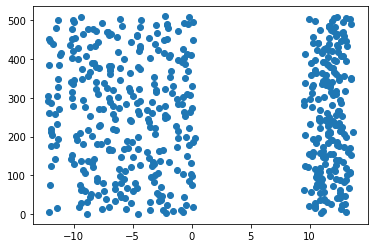

In [21]:
draw_umap(n_components=1)

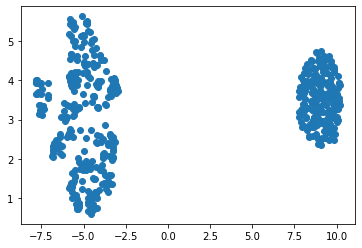

In [22]:
draw_umap(n_components=2)

d) **METRIC 5** Seperation of the latent space using low dimensional visuals, non-linear projection t-SNE. If we can see clear seperation in lower dimensional space, that means that latent variables are not bad. 

Now we will apply t-SNE (t-Distributed Stochastic Neighbor Embedding) is nonlinear dimensionality reduction technique in which interrelated high dimensional data (usually hundreds or thousands of variables) is mapped into low-dimensional data (like 2 or 3 variables) while preserving the significant structure (relationship among the data points in different variables) of original high dimensional data.

Note, we applied UMAP on the PCA projected space. For t-SNE we apply it on the raw data.

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


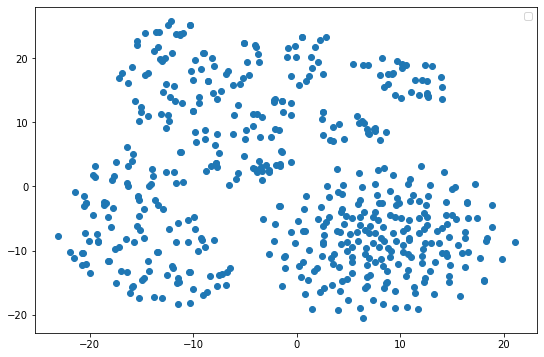

In [23]:
tsne = TSNE(n_components=2, random_state=0).fit_transform(model._vq_vae._embedding.weight.data.cpu())
x, y = list(zip(*tsne))

plt.figure(figsize=(9, 6))
plt.scatter(x, y)
plt.legend()
plt.show()

e) **METRIC 6**, Comparing different lengths of motifs (7-9-11) to a standard DB using TomTom tool https://meme-suite.org/meme/tools/tomtom

However, there TomTom is only available through R, hence I used gimmemotifs: https://gimmemotifs.readthedocs.io/en/master/reference.html#gimme-scan

First we have to convert the one hot encoded sequences to the original raw motif sequence.

**NOTE**

Change the following variable to control the motif length.

Be carefull, the smaller the number that we set, the more memory will be consumed and it will run longer.

In [24]:
MOTIF_LENGTH=200

Here we reverse the one hot encoding of the predictions from VQ-VAE

In [25]:
df_raw_sequences=[]
# iterate over all sequences
for batch_prediction in whole_predictions_full:
    for prediction in batch_prediction:
      motif_holder=[]
      for nucleotide in prediction[0]:
        motif_holder.append(NUCLEOTIDES_REVERSED[nucleotide.item()])

      df_raw_sequences.append(''.join(motif_holder))

Now we need to convert this list to either FASTA or bed and feed it to the gimme scan command in order to check occurances of motifs in jaspar vertebrates database

In [26]:
def save_motifs_to_fasta(motifs, fasta_file):
    # Open the FASTA file in write mode
    with open(fasta_file, 'w') as f:
        # Iterate over the motifs
        for i, motif in enumerate(motifs):
          for j in range(200//MOTIF_LENGTH):
            # Write the motif to the file
            f.write(f'>motif_{i+1}_{j+1}\n{motif[j*MOTIF_LENGTH:(j+1)*MOTIF_LENGTH]}\n')

save_motifs_to_fasta(df_raw_sequences, "recoded_motifs_seqs.fasta")

In [27]:
def motifs_from_fasta(fasta):
    """
    Extract motifs from fasta.
    """
    print ('Computing Motifs....')
    !gimme scan $fasta -p  JASPAR2020_vertebrates -g hg38 > train_results_motifs.bed
    df_results_seq_guime = pd.read_csv('train_results_motifs.bed', sep='\t', skiprows=5, header=None)
    return df_results_seq_guime

In [28]:
%%time
df_results_seq_guime=motifs_from_fasta('recoded_motifs_seqs.fasta')

Computing Motifs....
2022-12-14 14:30:49,383 - INFO - No config found.
2022-12-14 14:30:49,383 - INFO - Creating new config.
2022-12-14 14:30:49,386 - INFO - Using included version of MDmodule.
2022-12-14 14:30:49,401 - WARNING - MEME not found. To include it you will have to install it.
2022-12-14 14:30:49,414 - WARNING - MEMEW not found. To include it you will have to install it.
2022-12-14 14:30:49,427 - WARNING - DREME not found. To include it you will have to install it.
2022-12-14 14:30:49,440 - WARNING - Weeder not found. To include it you will have to install it.
2022-12-14 14:30:49,454 - WARNING - GADEM not found. To include it you will have to install it.
2022-12-14 14:30:49,454 - INFO - Using included version of MotifSampler.
2022-12-14 14:30:49,467 - WARNING - Trawler not found. To include it you will have to install it.
2022-12-14 14:30:49,467 - INFO - Using included version of Improbizer.
2022-12-14 14:30:49,467 - INFO - Using included version of BioProspector.
2022-12-14

In [29]:
df_results_seq_guime

,0,1,2,3,4,5,6,7,8
0,motif_1_1,pfmscan,misc_feature,133,144,10.743772,-,.,"motif_name ""MA0465.2_CDX2"" ; motif_instance ""T..."
1,motif_1_1,pfmscan,misc_feature,77,89,9.295637,-,.,"motif_name ""MA0114.4_HNF4A"" ; motif_instance ""..."
2,motif_1_1,pfmscan,misc_feature,77,89,9.161552,-,.,"motif_name ""MA0484.2_HNF4G"" ; motif_instance ""..."
3,motif_1_1,pfmscan,misc_feature,78,86,8.922553,+,.,"motif_name ""MA1534.1_NR1I3"" ; motif_instance ""..."
4,motif_1_1,pfmscan,misc_feature,124,135,10.158267,-,.,"motif_name ""MA0070.1_PBX1"" ; motif_instance ""T..."
...,...,...,...,...,...,...,...,...,...
335890,motif_29857_1,pfmscan,misc_feature,44,54,9.495406,-,.,"motif_name ""MA1648.1_TCF12(var.2)"" ; motif_ins..."
335891,motif_29857_1,pfmscan,misc_feature,44,54,9.689605,-,.,"motif_name ""MA0522.3_TCF3"" ; motif_instance ""G..."
335892,motif_29857_1,pfmscan,misc_feature,44,54,9.218449,-,.,"motif_name ""MA0103.3_ZEB1"" ; motif_instance ""G..."
335893,motif_29857_1,pfmscan,misc_feature,27,43,7.443503,-,.,"motif_name ""MA1597.1_ZNF528"" ; motif_instance ..."


In [30]:
N_MOTIF_OCCURANCES_TO_PLOT=20

In [ ]:
sns.countplot(y='motifs',data=df_results_seq_guime, order=pd.value_counts(df_results_seq_guime['motifs']).iloc[:N_MOTIF_OCCURANCES_TO_PLOT].index)